# Plottings

1. calibration curse of FB13-ComplEx and WN-TransE
2. training losses

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

from ampligraph.evaluation import generate_corruptions_for_fit, generate_corruptions_for_eval

In [2]:
from ampligraph.utils import restore_model
import os
from sklearn.calibration import CalibrationDisplay
from scipy.special import expit
from sklearn.metrics import accuracy_score

In [3]:
path = r'F:\TREAT\kgcal\saved_models\fb_comp'
fb_comps = { p: restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))}

path = r'F:\TREAT\kgcal\saved_models\wn_transe'
wn_trans = { p: restore_model(os.path.join(path, p)) for p in os.listdir(path)  if os.path.isfile(os.path.join(path, p))}


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:\\TREAT\\kgcal\\saved_models\\fb_comp'

In [5]:
ds = get_datasets()

## calibration curves of differnet losse

In [6]:

def plot_cal(model, data, ax=None, name=''):
    scores = model.predict(data.X_test)
    probs = expit(scores)
    print(probs)
    CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=name, n_bins=10)


[0.9999819  0.02084817 0.8461259  ... 0.99826765 0.03930025 0.25571385]
[5.34305215e-01 1.26168815e-11 7.01739872e-03 ... 1.04030340e-04
 2.99927929e-14 1.14422125e-10]
[0.8795546  0.28497428 0.5074157  ... 0.8274949  0.45049557 0.5181158 ]
[1.2824890e-01 4.2509560e-06 1.0577977e-02 ... 3.3432611e-06 1.3676887e-04
 9.9993686e-06]


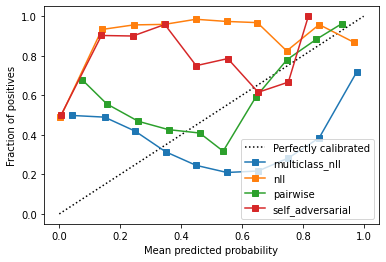

In [ ]:
fig, ax = plt.subplots()
for name, model in fb_comps.items():
    plot_cal(model, ds.fb13, ax, name[5:-4])

[1.1102993e-11 6.2716198e-19 3.2038752e-13 ... 1.4398927e-19 1.9294772e-12
 3.3135889e-16]
[0.47957966 0.0210171  0.08171045 ... 0.00153512 0.35107994 0.07741338]
[3.52228162e-05 2.24648898e-06 1.39712965e-05 ... 2.46173568e-06
 1.27716303e-05 4.87206898e-06]
[3.5183436e-01 9.9645426e-05 4.6595401e-04 ... 5.6892040e-04 5.8493394e-02
 4.5760788e-04]


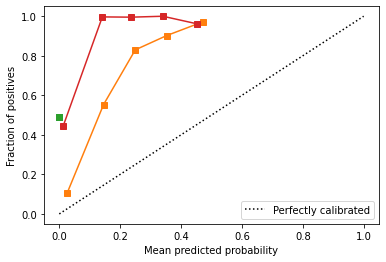

In [ ]:
fig, ax = plt.subplots()
for name, model in wn_trans.items():
    plot_cal(model, ds.wn18, ax, name=name[6:-4])

## Accuracy for complEx on FB13k (1000 epoches) of difference losses

In [7]:
def plot_accs(models, data, ax=None, names=''):
    accs = {}
    for model, name in zip(models, names):
        scores = model.predict(data.X_test)
        probs = expit(scores)
        preds = probs > 0.5
        accs[name] = accuracy_score(data.y_test, preds)
    print(accs)
    pd.Series(accs).round(3).plot(kind='bar')

{'m_nll': 0.5532614191808528, 'nll': 0.5081746165514917, 'pairwise': 0.5504803640653969, 'self_adv': 0.5002949603910332}


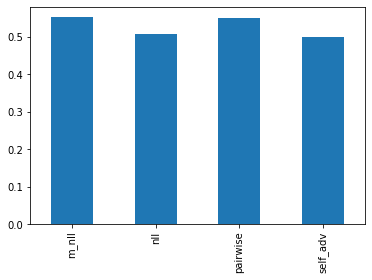

In [ ]:
plot_accs(fb_comps.values(), ds.fb13, names=['m_nll', 'nll', 'pairwise', 'self_adv'])

## Histogram of scores and probas for ComplEx of differnet losses

In [8]:
def plot_score_hist(model, data, ax, name=''):
    scores = model.predict(data.X_test)
    ax.hist(scores)
    ax.set_title(name)

def plot_prob_hist(model, data, ax, name=''):
    scores = model.predict(data.X_test)
    probs = expit(scores)
    ax.hist(probs)
    ax.set_xlim(0, 1)
    ax.set_title(name)

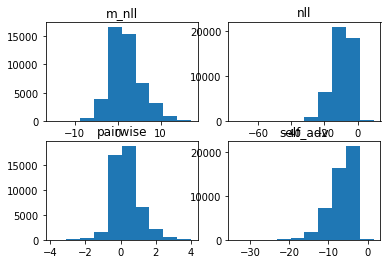

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_score_hist(fb_comps[0], ds.fb13, axes[0][0], 'm_nll')
plot_score_hist(fb_comps[1], ds.fb13, axes[0][1], 'nll')
plot_score_hist(fb_comps[2], ds.fb13, axes[1][0], 'pairwise')
plot_score_hist(fb_comps[3], ds.fb13, axes[1][1], 'self_adv')

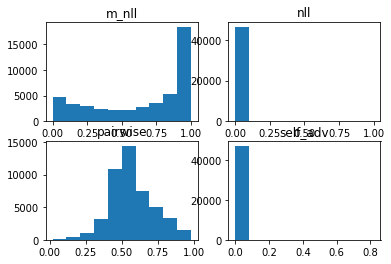

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(fb_comps[0], ds.fb13, axes[0][0], 'm_nll')
plot_prob_hist(fb_comps[1], ds.fb13, axes[0][1], 'nll')
plot_prob_hist(fb_comps[2], ds.fb13, axes[1][0], 'pairwise')
plot_prob_hist(fb_comps[3], ds.fb13, axes[1][1], 'self_adv')

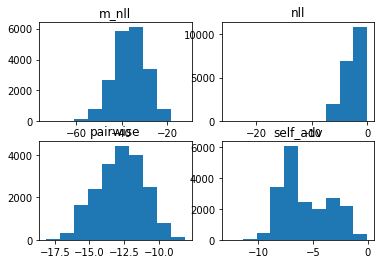

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_score_hist(wn_trans[0], ds.wn18, axes[0][0], 'm_nll')
plot_score_hist(wn_trans[1], ds.wn18, axes[0][1], 'nll')
plot_score_hist(wn_trans[2], ds.wn18, axes[1][0], 'pairwise')
plot_score_hist(wn_trans[3], ds.wn18, axes[1][1], 'self_adv')

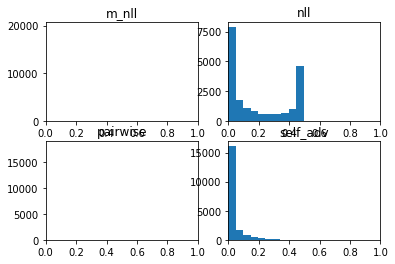

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(wn_trans[0], ds.wn18, axes[0][0], 'm_nll')
plot_prob_hist(wn_trans[1], ds.wn18, axes[0][1], 'nll')
plot_prob_hist(wn_trans[2], ds.wn18, axes[1][0], 'pairwise')
plot_prob_hist(wn_trans[3], ds.wn18, axes[1][1], 'self_adv')


[1.1102993e-11 6.2716198e-19 3.2038752e-13 ... 1.4398927e-19 1.9294772e-12
 3.3135889e-16]


(array([1.9705e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.0497993e-32, 3.6942828e-07, 7.3885656e-07, 1.1082849e-06,
        1.4777131e-06, 1.8471414e-06, 2.2165698e-06, 2.5859981e-06,
        2.9554262e-06, 3.3248546e-06, 3.6942829e-06], dtype=float32),
 <BarContainer object of 10 artists>)

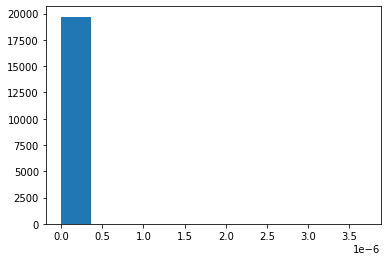

In [ ]:
# probs of m_nll and pairwise are too small is illustrate within the x-axis [0, 1]
p = expit(wn_trans[0].predict(ds.wn18.X_test))
print(p)
plt.hist(p)

[3.52228162e-05 2.24648898e-06 1.39712965e-05 ... 2.46173568e-06
 1.27716303e-05 4.87206898e-06]


(array([1.8234e+04, 9.8700e+02, 2.9500e+02, 1.0700e+02, 5.4000e+01,
        1.5000e+01, 7.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.3573886e-08, 2.9075369e-05, 5.8137164e-05, 8.7198961e-05,
        1.1626075e-04, 1.4532254e-04, 1.7438435e-04, 2.0344614e-04,
        2.3250793e-04, 2.6156972e-04, 2.9063152e-04], dtype=float32),
 <BarContainer object of 10 artists>)

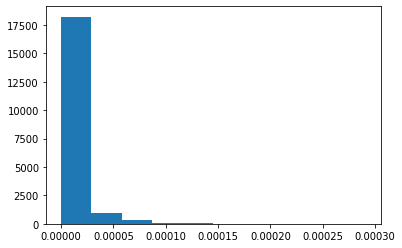

In [ ]:
p = expit(wn_trans[2].predict(ds.wn18.X_test))
print(p)
plt.hist(p)

In [ ]:
exp = Experiment([],[],[],[])
exp.load_trained_kges('../saved_models/trained_kges/')

Loaded trained KG embedding models.


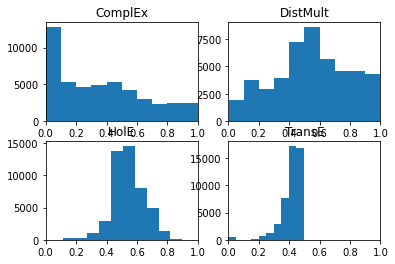

In [ ]:
from probcalkge import get_cls_name
fbs = exp.trained_kges['FB13k']
fig, axes = plt.subplots(2, 2)
for i, m in enumerate(fbs.values()):
    plot_prob_hist(m, ds.fb13, axes[i // 2][i % 2], get_cls_name(m))

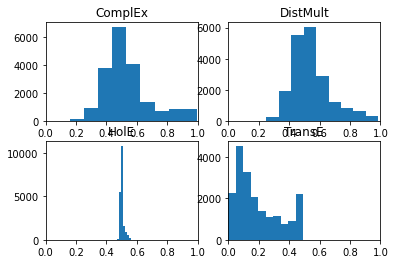

In [ ]:
wns = exp.trained_kges['WN11']
fig, axes = plt.subplots(2, 2)
for i, m in enumerate(wns.values()):
    plot_prob_hist(m, ds.wn18, axes[i // 2][i % 2], get_cls_name(m))

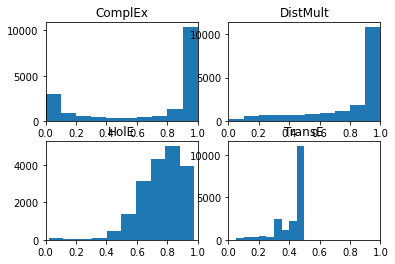

In [ ]:
ygs = exp.trained_kges['YAGO39']
fig, axes = plt.subplots(2, 2)
for i, m in enumerate(ygs.values()):
    plot_prob_hist(m, ds.yago39, axes[i // 2][i % 2], get_cls_name(m))

## 200 vs 300 vs 200reg for DistMult

In [ ]:
path = r'F:\TREAT\kgcal\saved_models\distmult'
dists = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

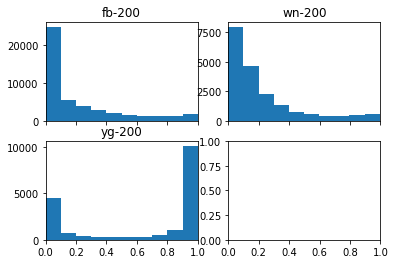

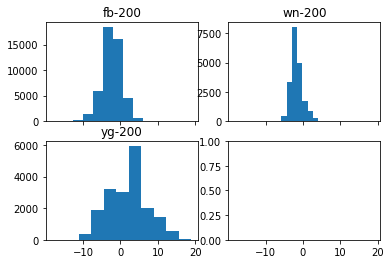

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[1], ds.fb13, axes[0][0], 'fb-200')
plot_prob_hist(dists[4], ds.wn18, axes[0][1], 'wn-200')
plot_prob_hist(dists[7], ds.yago39, axes[1][0], 'yg-200')

fig, axes = plt.subplots(2, 2, sharex=True)
plot_score_hist(dists[1], ds.fb13, axes[0][0], 'fb-200')
plot_score_hist(dists[4], ds.wn18, axes[0][1], 'wn-200')
plot_score_hist(dists[7], ds.yago39, axes[1][0], 'yg-200')



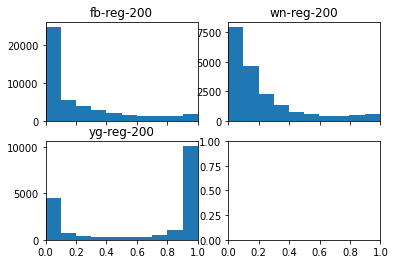

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[0], ds.fb13, axes[0][0], 'fb-reg-200')
plot_prob_hist(dists[3], ds.wn18, axes[0][1], 'wn-reg-200')
plot_prob_hist(dists[6], ds.yago39, axes[1][0], 'yg-reg-200')

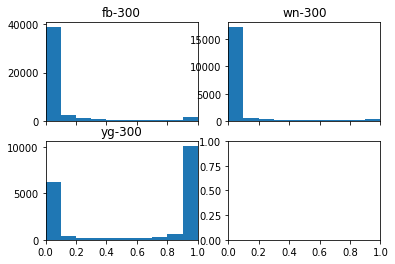

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[2], ds.fb13, axes[0][0], 'fb-300')
plot_prob_hist(dists[5], ds.wn18, axes[0][1], 'wn-300')
plot_prob_hist(dists[8], ds.yago39, axes[1][0], 'yg-300')


In [ ]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\am_100'
am100 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

In [ ]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\nll_100'
nll100 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

In [ ]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\nll_200'
nll200 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

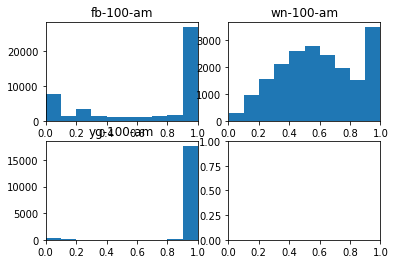

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(am100[0], ds.fb13, axes[0][0], 'fb-100-am')
plot_prob_hist(am100[1], ds.wn18, axes[0][1], 'wn-100-am')
plot_prob_hist(am100[2], ds.yago39, axes[1][0], 'yg-100-am')



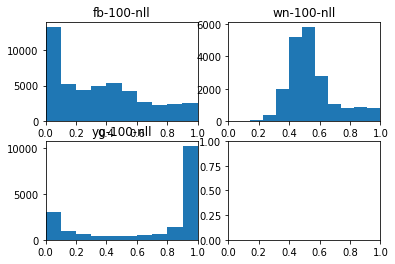

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(nll100[0], ds.fb13, axes[0][0], 'fb-100-nll')
plot_prob_hist(nll100[1], ds.wn18, axes[0][1], 'wn-100-nll')
plot_prob_hist(nll100[2], ds.yago39, axes[1][0], 'yg-100-nll')


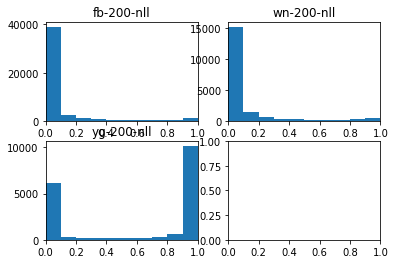

In [ ]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(nll200[0], ds.fb13, axes[0][0], 'fb-200-nll')
plot_prob_hist(nll200[1], ds.wn18, axes[0][1], 'wn-200-nll')
plot_prob_hist(nll200[2], ds.yago39, axes[1][0], 'yg-200-nll')


See if the models used early stopping (non-overfitting) could show well-calibrated native probabiilties

In [9]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\early'
earlys = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

{'HolE': 0.5582336086296983, 'ComplEx': 0.581682959716838, 'DistMult': 0.5449393224338446}
[0.6925139  0.39904365 0.92699534 ... 0.6872333  0.34233636 0.43563437]
[0.90829635 0.00772888 0.01843274 ... 0.85307276 0.00166045 0.10163447]
[0.9148484  0.16706169 0.30414042 ... 0.87475467 0.1571675  0.2350038 ]


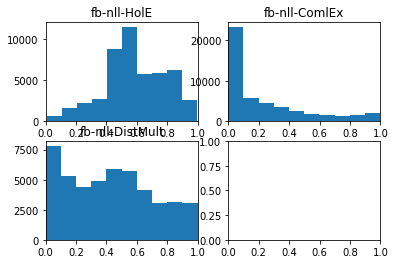

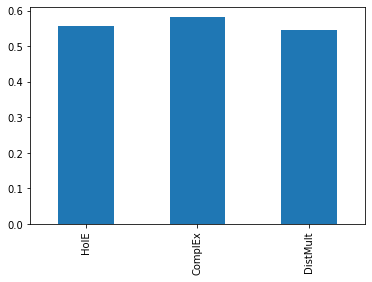

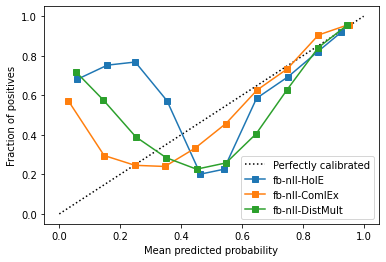

In [23]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(earlys[0], ds.fb13, axes[0][0], 'fb-nll-HolE')
plot_prob_hist(earlys[1], ds.fb13, axes[0][1], 'fb-nll-ComlEx')
plot_prob_hist(earlys[2], ds.fb13, axes[1][0], 'fb-nll-DistMult')

fig, ax = plt.subplots()
plot_accs(earlys[0: 3], ds.fb13, ax, ['HolE', 'ComplEx', 'DistMult'])

fig, ax = plt.subplots()
plot_cal(earlys[0], ds.fb13, ax, 'fb-nll-HolE')
plot_cal(earlys[1], ds.fb13, ax, 'fb-nll-ComlEx')
plot_cal(earlys[2], ds.fb13, ax, 'fb-nll-DistMult')


{'HolE': 0.6358976961331574, 'ComplEx': 0.6396528975946413, 'DistMult': 0.6043337054704151}
[0.9774711  0.33249167 0.32819435 ... 0.48149246 0.5986119  0.5484344 ]
[0.9611358  0.17604186 0.15840659 ... 0.4667138  0.47862512 0.440194  ]
[0.85445094 0.3967904  0.6052396  ... 0.53064877 0.57142913 0.5229631 ]


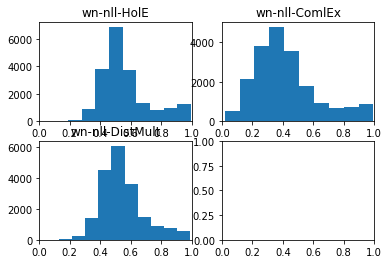

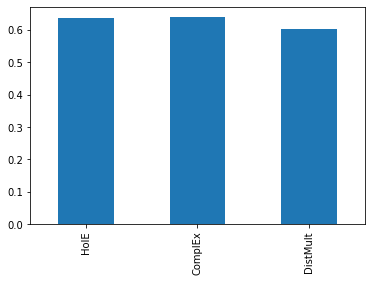

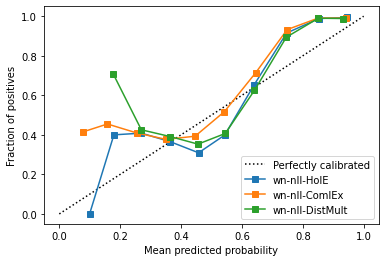

In [24]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(earlys[3], ds.wn18, axes[0][0], 'wn-nll-HolE')
plot_prob_hist(earlys[4], ds.wn18, axes[0][1], 'wn-nll-ComlEx')
plot_prob_hist(earlys[5], ds.wn18, axes[1][0], 'wn-nll-DistMult')


fig, ax = plt.subplots()
plot_accs(earlys[3: 6], ds.wn18, ax, ['HolE', 'ComplEx', 'DistMult'])

fig, ax = plt.subplots()
plot_cal(earlys[3], ds.wn18, ax, 'wn-nll-HolE')
plot_cal(earlys[4], ds.wn18, ax, 'wn-nll-ComlEx')
plot_cal(earlys[5], ds.wn18, ax, 'wn-nll-DistMult')

{'HolE': 0.5158588642135408, 'ComplEx': 0.7567947263197708, 'DistMult': 0.687901874966229}
[0.9188912  0.946035   0.8944523  ... 0.75160027 0.6347759  0.9450895 ]
[9.9919766e-01 9.9984479e-01 9.4262922e-01 ... 7.1804710e-03 4.2417330e-05
 5.0273991e-01]
[0.99793434 0.99972147 0.8237731  ... 0.20254725 0.00710565 0.8084528 ]


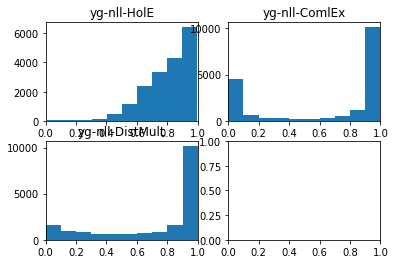

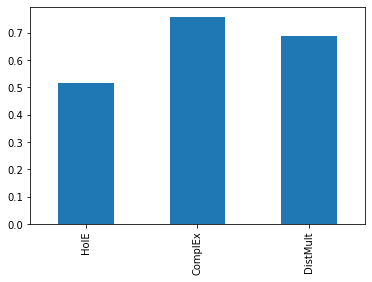

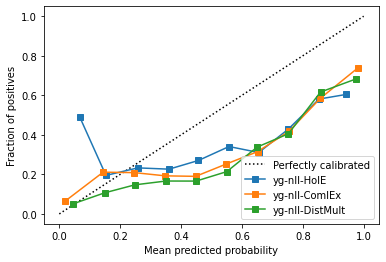

In [25]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(earlys[6], ds.yago39, axes[0][0], 'yg-nll-HolE')
plot_prob_hist(earlys[7], ds.yago39, axes[0][1], 'yg-nll-ComlEx')
plot_prob_hist(earlys[8], ds.yago39, axes[1][0], 'yg-nll-DistMult')

fig, ax = plt.subplots()
plot_accs(earlys[6: ], ds.yago39, ax, ['HolE', 'ComplEx', 'DistMult'])

fig, ax = plt.subplots()
plot_cal(earlys[6], ds.yago39, ax, 'yg-nll-HolE')
plot_cal(earlys[7], ds.yago39, ax, 'yg-nll-ComlEx')
plot_cal(earlys[8], ds.yago39, ax, 'yg-nll-DistMult')

In [ ]:
plot_accs